In [295]:
# Import libraries
import torch
import torch.nn as nn
from torch import optim
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split, Subset
import torch.nn.functional as F

# A module to print a model summary (outputs shape, number of parameters, ...)
import torchsummary

# TensorBoard for visualization
from torch.utils.tensorboard import SummaryWriter

from tqdm import tqdm

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

from PIL import Image
from sklearn.model_selection import train_test_split
import time
import random

import cv2

# Custom modules and packages
import params.learning


## Prepare data

In [296]:
# Define the data to be used
DATASET = "../../datasets/dataset_to_delete/"


class TraversabilityDataset(Dataset):
    """Custom Dataset class to represent our dataset
    It includes data and information about the data

    Args:
        Dataset (class): Abstract class which represents a dataset
    """
    
    def __init__(self, traversal_costs_file, images_directory,
                 transform_image=None,
                 transform_depth=None,):
        """Constructor of the class

        Args:
            traversal_costs_file (string): Path to the csv file which contains
            images index and their associated traversal cost
            images_directory (string): Directory with all the images
            transform (callable, optional): Transforms to be applied on a
            sample. Defaults to None.
        """
        # Read the csv file
        self.traversal_costs_frame = pd.read_csv(traversal_costs_file,
                                                 converters={"image_id": str})
        
        # Initialize the name of the images directory
        self.images_directory = images_directory
        
        # Initialize the transforms
        self.transform_image = transform_image
        self.transform_depth = transform_depth

    def __len__(self):
        """Return the size of the dataset

        Returns:
            int: Number of samples
        """
        # Count the number of files in the image directory
        # return len(os.listdir(self.images_directory))
        return len(self.traversal_costs_frame)

    def __getitem__(self, idx):
        """Allow to access a sample by its index

        Args:
            idx (int): Index of a sample

        Returns:
            list: Sample at index idx
            ([image, traversal_cost])
        """
        # Get the image name at index idx
        image_name = os.path.join(self.images_directory,
                                  self.traversal_costs_frame.loc[idx, "image_id"])
        
        # Read the image
        image = Image.open(image_name + ".png")
        
        # Eventually apply transforms to the image
        if self.transform_image:
            image = self.transform_image(image)
            
        # Read the depth image
        depth_image = Image.open(image_name + ".tiff")
        
        # Eventually apply transforms to the depth image
        if self.transform_depth:
            depth_image = self.transform_depth(depth_image)
        
        # Concatenate the image and depth image
        multimodal_image = torch.cat((image, depth_image))
        
        # Get the corresponding traversal cost
        traversal_cost = self.traversal_costs_frame.loc[idx, "traversal_cost"]
        
        # Get the corresponding traversability label
        traversability_label = self.traversal_costs_frame.loc[idx, "traversability_label"]
        
        # Get the corresponding linear velocity
        linear_velocity = self.traversal_costs_frame.loc[idx, "linear_velocity"]

        return multimodal_image, traversal_cost, traversability_label, linear_velocity

In [297]:
def compute_mean_std(images_directory, traversal_costs_file):
    """Compute the mean and standard deviation of the images of the dataset

    Args:
        images_directory (string): Directory with all the images
        traversal_costs_file (string): Name of the csv file which contains
        images index and their associated traversal cost

    Returns:
        torch::Tensor: Mean and standard deviation of the dataset
    """
    transform = transforms.Compose([
        # Reduce the size of the images
        # (if size is an int, the smaller edge of the
        # image will be matched to this number and the ration is kept)
        transforms.Resize((70, 210)),

        # Convert a PIL Image or numpy.ndarray to tensor
        transforms.ToTensor(),
    ])
     
    # Create a Dataset for training
    dataset = TraversabilityDataset(
        traversal_costs_file=DATASET+traversal_costs_file,
        images_directory=DATASET+images_directory,
        transform_image=transform,
        transform_depth=transform
    )
     
    loader = DataLoader(
        dataset=dataset,
        batch_size=1,
        shuffle=False,
        num_workers=12,
        pin_memory=True
    )

    cnt = 0
    first_moment = torch.empty(4)
    second_moment = torch.empty(4)

    for images, traversal_costs, traversability_labels, linear_velocity in loader:
        b, c, h, w = images.shape
        nb_pixels = b * h * w
        sum_ = torch.sum(images, dim=[0, 2, 3])
        sum_of_square = torch.sum(images ** 2, dim=[0, 2, 3])
        first_moment = (cnt * first_moment + sum_) / (cnt + nb_pixels)
        second_moment = (cnt * second_moment + sum_of_square) / (cnt + nb_pixels)
        cnt += nb_pixels

    mean = first_moment
    std = torch.sqrt(second_moment - first_moment ** 2)
    
    return mean, std

In [298]:
mean, std = compute_mean_std("images_train", "traversal_costs_train.csv")
print(mean, std)

tensor([0.4292, 0.4311, 0.4138, 1.2411]) tensor([0.1345, 0.1260, 0.1251, 0.4020])


In [299]:
# Compose several transforms together to be applied to training data
# (Note that transforms are not applied yet)
train_transform = transforms.Compose([
    # Reduce the size of the images
    # (if size is an int, the smaller edge of the
    # image will be matched to this number and the ration is kept)
    # transforms.Resize(100),
    transforms.Resize((70, 210)),
    
    # Perform horizontal flip of the image with a probability of 0.5
    # transforms.RandomHorizontalFlip(p=0.5),
    
    # Modify the brightness and the contrast of the image
    transforms.ColorJitter(contrast=0.5, brightness=0.5),
    
    # Convert a PIL Image or numpy.ndarray to tensor
    transforms.ToTensor(),
    
    # Add some random gaussian noise to the image
    transforms.Lambda(lambda x: x + (0.001**0.5)*torch.randn(x.shape)),
    
    # Normalize a tensor image with pre-computed mean and standard deviation
    # (based on the data used to train the model(s))
    # (be careful, it only works on torch.*Tensor)
    transforms.Normalize(
        # mean=[0.485, 0.456, 0.406],
        # std=[0.229, 0.224, 0.225]
        mean=mean[:3],
        std=std[:3]
    ),
])

# Define a different set of transforms testing
# (for instance we do not need to flip the image)
test_transform = transforms.Compose([
    # transforms.Resize(100),
    transforms.Resize((70, 210)),
    # transforms.Grayscale(),
    # transforms.CenterCrop(100),
    # transforms.RandomCrop(100),
    transforms.ToTensor(),
    
    # Mean and standard deviation were pre-computed on the training data
    # (on the ImageNet dataset)
    transforms.Normalize(
        # mean=[0.485, 0.456, 0.406],
        # std=[0.229, 0.224, 0.225]
        mean=mean[:3],
        std=std[:3]
    ),
])

transform_depth = transforms.Compose([
        # Reduce the size of the images
        # (if size is an int, the smaller edge of the
        # image will be matched to this number and the ration is kept)
        transforms.Resize((70, 210)),

        # Convert a PIL Image or numpy.ndarray to tensor
        transforms.ToTensor(),
        
        # Normalize a tensor image with pre-computed mean and standard deviation
        # (based on the data used to train the model(s))
        # (be careful, it only works on torch.*Tensor)
        transforms.Normalize(
            mean=mean[3],
            std=std[3]
        ),
])


# Create a Dataset for training
train_set = TraversabilityDataset(
    traversal_costs_file=DATASET+"traversal_costs_train.csv",
    images_directory=DATASET+"images_train",
    transform_image=train_transform,
    transform_depth=transform_depth
)

# Create a Dataset for validation
val_set = TraversabilityDataset(
    traversal_costs_file=DATASET+"traversal_costs_train.csv",
    images_directory=DATASET+"images_train",
    transform_image=test_transform,
    transform_depth=transform_depth
)

# Create a Dataset for testin
test_set = TraversabilityDataset(
    traversal_costs_file=DATASET+"traversal_costs_test.csv",
    images_directory=DATASET+"images_test",
    transform_image=test_transform,
    transform_depth=transform_depth
)

# Set the train dataset size
# 70% of the total data is used for training, 15% for validation
# and 15% for testing
train_size = 70/(100-15)

# Splits train data indices into train and validation data indices
train_indices, val_indices = train_test_split(range(len(train_set)), train_size=train_size)

# Extract the corresponding subsets of the train dataset
train_set = Subset(train_set, train_indices)
val_set = Subset(val_set, val_indices)


# Combine a dataset and a sampler, and provide an iterable over the dataset
# (setting shuffle argument to True calls a RandomSampler, and avoids to
# have to create a Sampler object)
train_loader = DataLoader(
    train_set,
    batch_size=params.learning.BATCH_SIZE,
    shuffle=True,
    num_workers=12,  # Asynchronous data loading and augmentation
    pin_memory=True,  # Increase the transferring speed of the data to the GPU
)

val_loader = DataLoader(
    val_set,
    batch_size=params.learning.BATCH_SIZE,
    shuffle=True,
    num_workers=12,
    pin_memory=True,
)

test_loader = DataLoader(
    test_set,
    batch_size=params.learning.BATCH_SIZE,
    shuffle=False,  # SequentialSampler
    num_workers=12,
    pin_memory=True,
)

In [300]:
images, traversal_costs, traversability_labels, linear_velocity = next(iter(train_loader))

print(torch.max(images[0]))
# print((torch.max(train_set[0][1])))

tensor(5.3203)


In [301]:
# Get the number of samples per split
NB_TRAIN = len(train_set)
NB_VAL = len(val_set)
NB_TEST = len(test_set)

In [302]:
# Display the splits ratio
NB_SAMPLES = NB_TRAIN + NB_VAL + NB_TEST

print(f"{np.round(NB_TRAIN/NB_SAMPLES*100)} % of the data for training ({NB_TRAIN} samples)")
print(f"{np.round(NB_VAL/NB_SAMPLES*100)} % of the data for validation ({NB_VAL} samples)")
print(f"{np.round(NB_TEST/NB_SAMPLES*100)} % of the data for testing ({NB_TEST} samples)")

70.0 % of the data for training (1152 samples)
15.0 % of the data for validation (247 samples)
15.0 % of the data for testing (247 samples)


## GPU?

In [303]:
# Use a GPU if available
# device = "cpu"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}\n")

Device: cuda



## Model design and initialization

In [304]:
class ResNet18Velocity(nn.Module):
    
    def __init__(self, num_classes=10, num_input_features=1):
        
        super(ResNet18Velocity, self).__init__()
        
        ## Image and depth image processing ##
        # Load the ResNet18 model with pretrained weights
        self.resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        # Replace the first convolutional layer to accept 4 channels
        self.resnet18.conv1 = nn.Conv2d(
            in_channels=4,
            out_channels=64,
            kernel_size=7, 
            stride=2,
            padding=3,
            bias=False
        )
        # Replace the last fully-connected layer to have n classes as output
        self.resnet18.fc = nn.Linear(self.resnet18.fc.in_features, num_classes)
        
        ## Numeric input processing ##
        self.fc = nn.Linear(num_input_features, 210*70*4)
        
    
    def forward(self, x_img, x_dense):
        
        # FC layer to convert the numeric input to the same shape as the
        # activation map
        x_dense = self.fc(x_dense)
        x_dense = x_dense.view(-1, 4, 70, 210) 
        
        # Element-wise product of the activation map and the main-
        # channel input
        x = x_img * x_dense
        
        # Forward pass through the ResNet18
        x = self.resnet18.conv1(x)
        x = self.resnet18.bn1(x)
        x = self.resnet18.relu(x)
        x = self.resnet18.maxpool(x)
        
        x = self.resnet18.layer1(x)
        x = self.resnet18.layer2(x)
        x = self.resnet18.layer3(x)
        x = self.resnet18.layer4(x)
        
        x = F.avg_pool2d(x, x.size()[2:])
        x = x.view(x.size(0), -1)
        x = self.resnet18.fc(x)
        
        return x

In [305]:
# Create a ResNet18 model
model = ResNet18Velocity().to(device=device)

In [306]:
# Create dummy tensors
images = torch.randn(32, 4, 70, 210).to(device=device)  # (batch, channels, height, width)
data = torch.randn(32, 1).to(device=device)  # (batch, features)

print(model(images, data).shape)

torch.Size([32, 10])


#### Visualize the model

In [307]:
# Open TensorBoard
tensorboard = SummaryWriter()

# Display the architecture in TensorBoard
images, traversal_costs, traversability_labels, linear_velocities = next(iter(train_loader))
images = images.to(device)
linear_velocities = linear_velocities.type(torch.float32).to(device)

# Add a dimension to the linear velocities tensor
linear_velocities.unsqueeze_(1)

tensorboard.add_graph(model, (images, linear_velocities))

# print(model)
# print(torchsummary.summary(model, (3, 100, 100)))
print([(name, param.shape) for name, param in model.named_parameters()])
# print(model.fc.state_dict())

[('resnet18.conv1.weight', torch.Size([64, 4, 7, 7])), ('resnet18.bn1.weight', torch.Size([64])), ('resnet18.bn1.bias', torch.Size([64])), ('resnet18.layer1.0.conv1.weight', torch.Size([64, 64, 3, 3])), ('resnet18.layer1.0.bn1.weight', torch.Size([64])), ('resnet18.layer1.0.bn1.bias', torch.Size([64])), ('resnet18.layer1.0.conv2.weight', torch.Size([64, 64, 3, 3])), ('resnet18.layer1.0.bn2.weight', torch.Size([64])), ('resnet18.layer1.0.bn2.bias', torch.Size([64])), ('resnet18.layer1.1.conv1.weight', torch.Size([64, 64, 3, 3])), ('resnet18.layer1.1.bn1.weight', torch.Size([64])), ('resnet18.layer1.1.bn1.bias', torch.Size([64])), ('resnet18.layer1.1.conv2.weight', torch.Size([64, 64, 3, 3])), ('resnet18.layer1.1.bn2.weight', torch.Size([64])), ('resnet18.layer1.1.bn2.bias', torch.Size([64])), ('resnet18.layer2.0.conv1.weight', torch.Size([128, 64, 3, 3])), ('resnet18.layer2.0.bn1.weight', torch.Size([128])), ('resnet18.layer2.0.bn1.bias', torch.Size([128])), ('resnet18.layer2.0.conv2.we

## Training and validation loops

In [308]:
def train(model, device, train_loader, optimizer, criterion_classification, criterion_regression, bins_midpoints, epoch):
    """Train the model for one epoch

    Args:
        model (Model): The model to train
        device (string): The device to use (cpu or cuda)
        train_loader (Dataloader): The training data loader
        optimizer (Optimizer): The optimizer to use
        criterion_classification (Loss): The classification loss to use
        criterion_regression (Loss): The regression loss to use
        bins_midpoints (ndarray): The midpoints of the bins used to discretize the traversal costs
        epoch (int): The current epoch

    Returns:
        double, double, double: The training loss, the training accuracy and the training regression loss
    """
    # Initialize the training loss and accuracy
    train_loss = 0.
    train_correct = 0
    train_regression_loss = 0.
    
    # Configure the model for training
    # (good practice, only necessary if the model operates differently for
    # training and validation)
    model.train()
    
    # Add a progress bar
    train_loader_pbar = tqdm(train_loader, unit="batch")
    
    # Loop over the training batches
    for images, traversal_costs, traversability_labels, linear_velocities in train_loader_pbar:
        
        # Print the epoch and training mode
        train_loader_pbar.set_description(f"Epoch {epoch} [train]")
        
        # Move images and traversal scores to GPU (if available)
        images = images.to(device)
        traversal_costs = traversal_costs.to(device)
        traversability_labels = traversability_labels.to(device)
        linear_velocities = linear_velocities.type(torch.float32).to(device)
        
        # Add a dimension to the linear velocities tensor
        linear_velocities.unsqueeze_(1)
        
        # Zero out gradients before each backpropagation pass, to avoid that
        # they accumulate
        optimizer.zero_grad()
        
        # Perform forward pass
        predicted_traversability_labels = model(images, linear_velocities)
        # predicted_traversal_scores = nn.Softmax(dim=1)(model(images))
        
        # Compute loss 
        loss = criterion_classification(predicted_traversability_labels, traversability_labels)
        
        # Print the batch loss next to the progress bar
        train_loader_pbar.set_postfix(batch_loss=loss.item())
        
        # Perform backpropagation (update weights)
        loss.backward()
        
        # Adjust parameters based on gradients
        optimizer.step()
        
        # Accumulate batch loss to average over the epoch
        train_loss += loss.item()
    
        # Get the number of correct predictions
        train_correct += torch.sum(
            torch.argmax(predicted_traversability_labels, dim=1) == traversability_labels
            ).item()
        
        # Compute the expected traversal cost over the bins
        expected_traversal_costs = torch.matmul(nn.Softmax(dim=1)(predicted_traversability_labels), bins_midpoints)
        
        # Compute and accumulate the batch loss
        train_regression_loss += criterion_regression(expected_traversal_costs[:, 0], traversal_costs).item()
    
    # Compute the losses and accuracies
    train_loss /= len(train_loader)
    train_accuracy = 100*train_correct/NB_TRAIN
    train_regression_loss /= len(train_loader)
        
    return train_loss, train_accuracy, train_regression_loss

In [309]:
def validate(model, device, val_loader, criterion_classification, criterion_regression, bins_midpoints, epoch):
    """Validate the model for one epoch

    Args:
        model (Model): The model to validate
        device (string): The device to use (cpu or cuda)
        val_loader (Dataloader): The validation data loader
        criterion_classification (Loss): The classification loss to use
        criterion_regression (Loss): The regression loss to use
        bins_midpoints (ndarray): The midpoints of the bins used to discretize the traversal costs
        epoch (int): The current epoch
        
    Returns:
        double, double, double: The validation loss, the validation accuracy and the validation regression loss
    """
    # Initialize the validation loss and accuracy
    val_loss = 0.
    val_correct = 0
    val_regression_loss = 0.
    
    # Configure the model for testing
    # (turn off dropout layers, batchnorm layers, etc)
    model.eval()
    
    # Add a progress bar
    val_loader_pbar = tqdm(val_loader, unit="batch")
    
    # Turn off gradients computation (the backward computational graph is built during
    # the forward pass and weights are updated during the backward pass, here we avoid
    # building the graph)
    with torch.no_grad():
        # Loop over the validation batches
        for images, traversal_costs, traversability_labels, linear_velocities in val_loader_pbar:

            # Print the epoch and validation mode
            val_loader_pbar.set_description(f"Epoch {epoch} [val]")

            # Move images and traversal scores to GPU (if available)
            images = images.to(device)
            traversal_costs = traversal_costs.to(device)
            traversability_labels = traversability_labels.to(device)
            linear_velocities = linear_velocities.type(torch.float32).to(device)
            
            # Add a dimension to the linear velocities tensor
            linear_velocities.unsqueeze_(1)
            
            # Perform forward pass (only, no backpropagation)
            predicted_traversability_labels = model(images, linear_velocities)
            # predicted_traversal_scores = nn.Softmax(dim=1)(model(images))

            # Compute loss
            loss = criterion_classification(predicted_traversability_labels, traversability_labels)

            # Print the batch loss next to the progress bar
            val_loader_pbar.set_postfix(batch_loss=loss.item())

            # Accumulate batch loss to average over the epoch
            val_loss += loss.item()
            
            # Get the number of correct predictions
            val_correct += torch.sum(
                torch.argmax(predicted_traversability_labels, dim=1) == traversability_labels
                ).item()
            
            # Compute the expected traversal cost over the bins
            expected_traversal_costs = torch.matmul(nn.Softmax(dim=1)(predicted_traversability_labels), bins_midpoints)

            # Compute and accumulate the batch loss
            val_regression_loss += criterion_regression(expected_traversal_costs[:, 0], traversal_costs).item()
        
    # Compute the losses and accuracies
    val_loss /= len(val_loader)
    val_accuracy = 100*val_correct/NB_VAL
    val_regression_loss /= len(val_loader)
    
    return val_loss, val_accuracy, val_regression_loss

In [310]:
# Define the loss function (combines nn.LogSoftmax() and nn.NLLLoss())
criterion_classification = nn.CrossEntropyLoss()

# Loss function to compare the expected traversal cost over the bins
# and the ground truth traversal cost
criterion_regression = nn.MSELoss()

# Load the bins midpoints
bins_midpoints = np.load(DATASET+"bins_midpoints.npy")
bins_midpoints = torch.tensor(bins_midpoints[:, None], dtype=torch.float32, device=device)

# Get all the parameters excepts the weights and bias of fc layer
base_params = [param for name, param in model.named_parameters()
               if name not in ["resnet18.fc.weight", "resnet18.fc.bias"]]

# Define the optimizer, with a greater learning rate for the new fc layer
optimizer = optim.SGD([
    {"params": base_params},
    {"params": model.resnet18.fc.parameters(), "lr": 1e-3},
],
    lr=1e-4, momentum=0.9, weight_decay=0.001)

# Create tensors to store the loss and accuracy values
loss_values = torch.zeros(2, params.learning.NB_EPOCHS)
accuracy_values = torch.zeros(2, params.learning.NB_EPOCHS)
regression_loss_values = torch.zeros(2, params.learning.NB_EPOCHS)

# Loop over the epochs
for epoch in range(params.learning.NB_EPOCHS):
    
    # Training
    train_loss, train_accuracy, train_regression_loss = train(model,
                                                              device,
                                                              train_loader,
                                                              optimizer,
                                                              criterion_classification,
                                                              criterion_regression,
                                                              bins_midpoints,
                                                              epoch)
    
    # Validation
    val_loss, val_accuracy, val_regression_loss = validate(model,
                                                           device,
                                                           val_loader,
                                                           criterion_classification,
                                                           criterion_regression,
                                                           bins_midpoints,
                                                           epoch) 
    
    print("Train accuracy: ", train_accuracy)
    print("Validation accuracy: ", val_accuracy)
    print("Train regression loss: ", train_regression_loss)
    print("Validation regression loss: ", val_regression_loss)
    
    # Store the computed losses
    loss_values[0, epoch] = train_loss
    loss_values[1, epoch] = val_loss
    # Store the computed accuracies
    accuracy_values[0, epoch] = train_accuracy
    accuracy_values[1, epoch] = val_accuracy
    # Store the computed regression losses
    regression_loss_values[0, epoch] = train_regression_loss
    regression_loss_values[1, epoch] = val_regression_loss
    
    # Add the losses to TensorBoard
    tensorboard.add_scalar("train_loss", train_loss, epoch)
    tensorboard.add_scalar("val_loss", val_loss, epoch)
    # Add the accuracies to TensorBoard
    tensorboard.add_scalar("train_accuracy", train_accuracy, epoch)
    tensorboard.add_scalar("val_accuracy", val_accuracy, epoch)
    # Add the regression losses to TensorBoard
    tensorboard.add_scalar("train_regression_loss", train_regression_loss, epoch)
    tensorboard.add_scalar("val_regression_loss", val_regression_loss, epoch)

# Close TensorBoard
tensorboard.close()

Epoch 0 [val]: 100%|██████████| 8/8 [00:01<00:00,  5.94batch/s, batch_loss=1.19]


Train accuracy:  41.927083333333336
Validation accuracy:  51.821862348178136
Train regression loss:  0.00018335102949242939
Validation regression loss:  4.744055429945122e-05


Epoch 1 [val]: 100%|██████████| 8/8 [00:01<00:00,  6.26batch/s, batch_loss=1.69] 


Train accuracy:  50.78125
Validation accuracy:  54.25101214574899
Train regression loss:  6.522878583346904e-05
Validation regression loss:  4.900080734643508e-05


Epoch 2 [val]: 100%|██████████| 8/8 [00:01<00:00,  5.98batch/s, batch_loss=1.27]


Train accuracy:  50.954861111111114
Validation accuracy:  48.178137651821864
Train regression loss:  6.403845397984405e-05
Validation regression loss:  4.5233201991663e-05


Epoch 3 [val]: 100%|██████████| 8/8 [00:01<00:00,  5.97batch/s, batch_loss=1.18]


Train accuracy:  52.083333333333336
Validation accuracy:  44.12955465587044
Train regression loss:  6.314536885567466e-05
Validation regression loss:  4.556474758240102e-05


Epoch 4 [val]: 100%|██████████| 8/8 [00:01<00:00,  6.24batch/s, batch_loss=0.852]


Train accuracy:  54.6875
Validation accuracy:  55.06072874493927
Train regression loss:  6.112440886512034e-05
Validation regression loss:  4.4139632207586404e-05


Epoch 5 [val]: 100%|██████████| 8/8 [00:01<00:00,  6.15batch/s, batch_loss=1.31]


Train accuracy:  52.517361111111114
Validation accuracy:  55.06072874493927
Train regression loss:  5.972371788773673e-05
Validation regression loss:  4.4332874781300005e-05


Epoch 6 [val]: 100%|██████████| 8/8 [00:01<00:00,  6.08batch/s, batch_loss=1.18] 


Train accuracy:  55.642361111111114
Validation accuracy:  52.63157894736842
Train regression loss:  6.092067711755463e-05
Validation regression loss:  4.3999958387766395e-05


Epoch 7 [val]: 100%|██████████| 8/8 [00:01<00:00,  6.25batch/s, batch_loss=1.13]


Train accuracy:  52.864583333333336
Validation accuracy:  55.06072874493927
Train regression loss:  5.945255708949743e-05
Validation regression loss:  4.4021454739090944e-05


Epoch 8 [val]: 100%|██████████| 8/8 [00:01<00:00,  5.87batch/s, batch_loss=1.29]


Train accuracy:  55.642361111111114
Validation accuracy:  56.2753036437247
Train regression loss:  5.816203098081847e-05
Validation regression loss:  4.399075415252094e-05


Epoch 9 [val]: 100%|██████████| 8/8 [00:01<00:00,  6.18batch/s, batch_loss=1.26] 


Train accuracy:  53.21180555555556
Validation accuracy:  52.63157894736842
Train regression loss:  5.847204959458394e-05
Validation regression loss:  4.470390262408911e-05


Epoch 10 [val]: 100%|██████████| 8/8 [00:01<00:00,  6.14batch/s, batch_loss=1.09]


Train accuracy:  53.298611111111114
Validation accuracy:  55.06072874493927
Train regression loss:  5.853536921633552e-05
Validation regression loss:  4.28955314966112e-05


Epoch 11 [val]: 100%|██████████| 8/8 [00:01<00:00,  6.16batch/s, batch_loss=1.4]  


Train accuracy:  56.510416666666664
Validation accuracy:  56.68016194331984
Train regression loss:  5.5943059886555536e-05
Validation regression loss:  4.3282591645142244e-05


Epoch 12 [val]: 100%|██████████| 8/8 [00:01<00:00,  5.82batch/s, batch_loss=1.03] 


Train accuracy:  54.60069444444444
Validation accuracy:  57.08502024291498
Train regression loss:  5.722509919394843e-05
Validation regression loss:  4.250219269397505e-05


Epoch 13 [val]: 100%|██████████| 8/8 [00:01<00:00,  6.18batch/s, batch_loss=1.24] 


Train accuracy:  57.204861111111114
Validation accuracy:  56.68016194331984
Train regression loss:  5.724437148112201e-05
Validation regression loss:  4.335993991586941e-05


Epoch 14 [val]: 100%|██████████| 8/8 [00:01<00:00,  6.03batch/s, batch_loss=1.09]


Train accuracy:  54.166666666666664
Validation accuracy:  55.465587044534416
Train regression loss:  5.535716007603061e-05
Validation regression loss:  4.5671038748132534e-05


Epoch 15 [val]: 100%|██████████| 8/8 [00:01<00:00,  6.11batch/s, batch_loss=1.2]  


Train accuracy:  54.77430555555556
Validation accuracy:  56.2753036437247
Train regression loss:  5.679738501657898e-05
Validation regression loss:  4.344038777623514e-05


Epoch 16 [val]: 100%|██████████| 8/8 [00:01<00:00,  5.62batch/s, batch_loss=0.943]


Train accuracy:  56.25
Validation accuracy:  56.2753036437247
Train regression loss:  5.618651946651674e-05
Validation regression loss:  4.346561768988543e-05


Epoch 17 [val]: 100%|██████████| 8/8 [00:01<00:00,  5.83batch/s, batch_loss=1.12] 


Train accuracy:  56.423611111111114
Validation accuracy:  54.25101214574899
Train regression loss:  5.5557415847155705e-05
Validation regression loss:  4.3113628878139524e-05


Epoch 18 [val]: 100%|██████████| 8/8 [00:01<00:00,  6.11batch/s, batch_loss=0.955]


Train accuracy:  55.81597222222222
Validation accuracy:  56.2753036437247
Train regression loss:  5.381957156312606e-05
Validation regression loss:  4.389750434233979e-05


Epoch 19 [val]: 100%|██████████| 8/8 [00:01<00:00,  6.28batch/s, batch_loss=1]    


Train accuracy:  57.72569444444444
Validation accuracy:  57.48987854251012
Train regression loss:  5.533659637636043e-05
Validation regression loss:  4.404031544394045e-05


Epoch 20 [val]: 100%|██████████| 8/8 [00:01<00:00,  5.83batch/s, batch_loss=1.32] 


Train accuracy:  57.638888888888886
Validation accuracy:  54.65587044534413
Train regression loss:  5.385031646422286e-05
Validation regression loss:  4.393122338694376e-05


Epoch 21 [val]: 100%|██████████| 8/8 [00:01<00:00,  6.09batch/s, batch_loss=1.45] 


Train accuracy:  58.420138888888886
Validation accuracy:  55.87044534412956
Train regression loss:  5.349232375757761e-05
Validation regression loss:  4.461609574594108e-05


Epoch 22 [val]: 100%|██████████| 8/8 [00:01<00:00,  6.26batch/s, batch_loss=1.37] 


Train accuracy:  59.46180555555556
Validation accuracy:  57.08502024291498
Train regression loss:  5.134782017867616e-05
Validation regression loss:  4.280419341341408e-05


Epoch 23 [val]: 100%|██████████| 8/8 [00:01<00:00,  6.28batch/s, batch_loss=1.11]


Train accuracy:  60.59027777777778
Validation accuracy:  57.89473684210526
Train regression loss:  5.218128775889039e-05
Validation regression loss:  4.270686065321546e-05


Epoch 24 [val]: 100%|██████████| 8/8 [00:01<00:00,  6.17batch/s, batch_loss=1.48] 


Train accuracy:  61.71875
Validation accuracy:  55.465587044534416
Train regression loss:  5.0060516849897806e-05
Validation regression loss:  4.3577938943863123e-05


Epoch 25 [val]: 100%|██████████| 8/8 [00:01<00:00,  5.92batch/s, batch_loss=1.1]  


Train accuracy:  59.72222222222222
Validation accuracy:  56.2753036437247
Train regression loss:  5.019811489403198e-05
Validation regression loss:  4.234206741961135e-05


Epoch 26 [val]: 100%|██████████| 8/8 [00:01<00:00,  6.35batch/s, batch_loss=1.29] 


Train accuracy:  60.763888888888886
Validation accuracy:  53.84615384615385
Train regression loss:  5.1532721287892966e-05
Validation regression loss:  4.2353608533761114e-05


Epoch 27 [val]: 100%|██████████| 8/8 [00:01<00:00,  5.94batch/s, batch_loss=1.33] 


Train accuracy:  60.329861111111114
Validation accuracy:  55.06072874493927
Train regression loss:  5.14194960471595e-05
Validation regression loss:  4.1970429070774454e-05


Epoch 28 [val]: 100%|██████████| 8/8 [00:01<00:00,  6.08batch/s, batch_loss=1.37] 


Train accuracy:  62.15277777777778
Validation accuracy:  57.48987854251012
Train regression loss:  4.996191492298001e-05
Validation regression loss:  4.15144473701327e-05


Epoch 29 [val]: 100%|██████████| 8/8 [00:01<00:00,  6.01batch/s, batch_loss=0.895]


Train accuracy:  61.63194444444444
Validation accuracy:  56.2753036437247
Train regression loss:  4.775312096821928e-05
Validation regression loss:  4.1921484597063134e-05


Epoch 30 [val]: 100%|██████████| 8/8 [00:01<00:00,  6.30batch/s, batch_loss=1.12] 


Train accuracy:  62.41319444444444
Validation accuracy:  59.10931174089069
Train regression loss:  4.8525635304360043e-05
Validation regression loss:  4.1196451042480576e-05


Epoch 31 [val]: 100%|██████████| 8/8 [00:01<00:00,  6.26batch/s, batch_loss=1.35]


Train accuracy:  63.802083333333336
Validation accuracy:  57.48987854251012
Train regression loss:  4.7536964534710084e-05
Validation regression loss:  4.138255310294268e-05


Epoch 32 [val]: 100%|██████████| 8/8 [00:01<00:00,  5.88batch/s, batch_loss=1.09] 


Train accuracy:  62.93402777777778
Validation accuracy:  57.08502024291498
Train regression loss:  4.6065727237864465e-05
Validation regression loss:  4.1192688088142354e-05


Epoch 33 [val]: 100%|██████████| 8/8 [00:01<00:00,  5.84batch/s, batch_loss=1.11] 


Train accuracy:  59.635416666666664
Validation accuracy:  54.65587044534413
Train regression loss:  4.9036102311096785e-05
Validation regression loss:  4.3682813550277085e-05


Epoch 34 [val]: 100%|██████████| 8/8 [00:01<00:00,  5.93batch/s, batch_loss=1.43] 


Train accuracy:  63.888888888888886
Validation accuracy:  57.89473684210526
Train regression loss:  4.966243297983955e-05
Validation regression loss:  4.164412950298545e-05


Epoch 35 [val]: 100%|██████████| 8/8 [00:01<00:00,  5.78batch/s, batch_loss=0.869]


Train accuracy:  64.0625
Validation accuracy:  56.68016194331984
Train regression loss:  4.829503360502036e-05
Validation regression loss:  4.488505598515929e-05


Epoch 36 [val]: 100%|██████████| 8/8 [00:01<00:00,  5.99batch/s, batch_loss=0.795]


Train accuracy:  63.541666666666664
Validation accuracy:  53.441295546558706
Train regression loss:  4.625463051586797e-05
Validation regression loss:  4.070136157629107e-05


Epoch 37 [val]: 100%|██████████| 8/8 [00:01<00:00,  6.25batch/s, batch_loss=1.17]


Train accuracy:  63.71527777777778
Validation accuracy:  57.89473684210526
Train regression loss:  4.6923621942396114e-05
Validation regression loss:  4.1779581016015235e-05


Epoch 38 [val]: 100%|██████████| 8/8 [00:01<00:00,  6.18batch/s, batch_loss=1.36]


Train accuracy:  65.10416666666667
Validation accuracy:  53.441295546558706
Train regression loss:  4.7757383692010595e-05
Validation regression loss:  4.407594934564574e-05


Epoch 39 [val]: 100%|██████████| 8/8 [00:01<00:00,  6.02batch/s, batch_loss=0.934]

Train accuracy:  63.71527777777778
Validation accuracy:  54.65587044534413
Train regression loss:  5.112048659740273e-05
Validation regression loss:  4.1033212537618695e-05


### Visualization

Text(0.5, 0, 'Epoch')

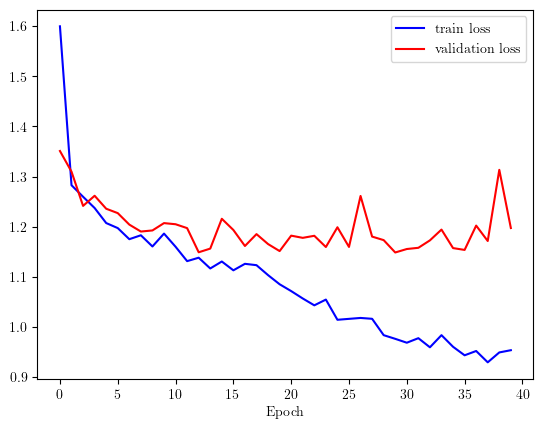

In [311]:
# Loss
train_losses = loss_values[0]
val_losses = loss_values[1]

plt.plot(train_losses, "b", label="train loss")
plt.plot(val_losses, "r", label="validation loss")

plt.legend()
plt.xlabel("Epoch")

Text(0.5, 0, 'Epoch')

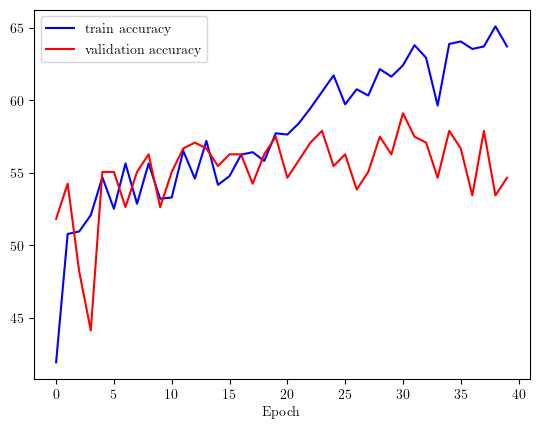

In [312]:
# Accuracy
train_accuracies = accuracy_values[0]
val_accuracies = accuracy_values[1]

plt.plot(train_accuracies, "b", label="train accuracy")
plt.plot(val_accuracies, "r", label="validation accuracy")

plt.legend()
plt.xlabel("Epoch")

Text(0.5, 0, 'Epoch')

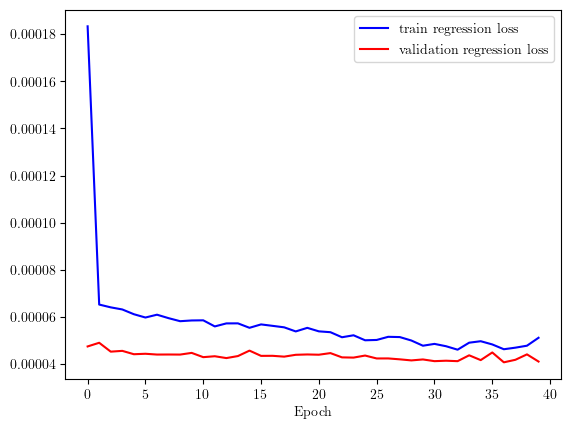

In [313]:
# Regression loss
train_regression_losses = regression_loss_values[0]
val_regression_losses = regression_loss_values[1]

plt.plot(train_regression_losses, "b", label="train regression loss")
plt.plot(val_regression_losses, "r", label="validation regression loss")

plt.legend()
plt.xlabel("Epoch")

## Testing

#### Uncertainty functions

In [314]:
def shannon_entropy(p):
    """
    Apply the Shannon entropy function to a probability distribution
    """
    return -torch.sum(p*torch.log(p), dim=1)

def least_confidence(p):
    """
    Apply the least confidence function to a probability distribution
    """
    return 1 - torch.max(p, dim=1)[0]

def confidence_margin(p):
    """
    Apply the margin sampling function to a probability distribution
    """
    sorted_p, _ = torch.sort(p, dim=1, descending=True)
    return 1 - (sorted_p[:, 0] - sorted_p[:, 1])


#### Regression error function

In [315]:
def squared_error(predicted_costs, true_costs):
    """
    Apply the squared error function to a predicted and true traversal cost
    """
    return (predicted_costs - true_costs)**2

#### Test function

In [316]:
def test(model, device, test_loader, criterion_classification, criterion_regression, bins_midpoints, uncertainty_function):
    """Test the model on the test set

    Args:
        model (Model): The model to test
        device (string): The device to use for the computations
        test_loader (Dataloader): The dataloader for the test set
        criterion_classification (Loss): The loss function for the classification task
        criterion_regression (Loss): The loss function for the regression task
        bins_midpoints (ndarray): The midpoints of the bins used for the discretization of the traversal cost
        uncertainty_function (function): The function to use to compute the uncertainty

    Returns:
        double, double, double, list, list: The average loss, the accuracy, the regression loss,
        the list of the uncertainties, the list of regression losses
    """
    # Testing
    test_loss = 0.
    test_correct = 0
    test_regression_loss = 0.

    # Configure the model for testing
    model.eval()

    test_regression_losses = []
    uncertainties = []

    with torch.no_grad():
        # Loop over the testing batches
        for images, traversal_costs, traversability_labels, linear_velocities in test_loader:

            images = images.to(device)
            traversal_costs = traversal_costs.to(device)
            traversability_labels = traversability_labels.to(device)
            linear_velocities = linear_velocities.type(torch.float32).to(device)

            # Add a dimension to the linear velocities tensor
            linear_velocities.unsqueeze_(1)
            
            # Perform forward pass
            predicted_traversability_labels = model(images, linear_velocities)

            # Compute loss
            loss = criterion_classification(predicted_traversability_labels, traversability_labels)
            
            # Accumulate batch loss to average of the entire testing set
            test_loss += loss.item()

            # Get the number of correct predictions
            test_correct += torch.sum(
                torch.argmax(predicted_traversability_labels, dim=1) == traversability_labels
                ).item()

            # Apply the softmax function to the predicted traversability labels
            probabilities = nn.Softmax(dim=1)(predicted_traversability_labels)

            # Compute the expected traversal cost over the bins
            expected_traversal_costs = torch.matmul(probabilities, bins_midpoints)
            
            # Compute and accumulate the batch loss
            test_regression_loss += criterion_regression(expected_traversal_costs[:, 0], traversal_costs).item()

            # Compute the loss for each sample
            test_regression_losses.append(squared_error(expected_traversal_costs[:, 0], traversal_costs).to("cpu"))
            
            # Compute the uncertainty
            uncertainties.append(uncertainty_function(probabilities).to("cpu"))

    # Compute the loss and accuracy
    test_loss /= len(test_loader)
    test_accuracy = 100*test_correct/NB_TEST
    
    # Compute the regression loss
    test_regression_loss /= len(test_loader)
   
    return test_loss, test_accuracy, test_regression_loss, test_regression_losses, uncertainties

#### Testing the model

In [317]:
# Set the uncertainty function
uncertainty_function = shannon_entropy

# Test the model
_, test_accuracy, test_regression_loss, test_regression_losses, uncertainties = test(model,
                                                                                     device,
                                                                                     test_loader,
                                                                                     criterion_classification,
                                                                                     criterion_regression,
                                                                                     bins_midpoints,
                                                                                     uncertainty_function)

print("Test accuracy: ", test_accuracy)
print("Regression loss: ", test_regression_loss)

Test accuracy:  57.89473684210526
Regression loss:  4.786596442439425e-05


## Save model parameters

In [25]:
# Save the model parameters
torch.save(model.state_dict(), "resnet18_velocity.params")

## Assessing the relevance of the uncertainty

In [320]:
def uncertainty_relevance(model,
                          device,
                          criterion_classification,
                          criterion_regression,
                          bins_midpoints,
                          uncertainty_function,
                          test_set,
                          test_regression_loss,
                          test_regression_losses,
                          uncertainties,
                          nb_samples=len(test_set)):
    """Compute the regression losses after successive removal of the samples with the highest loss and uncertainty

    Args:
        model (Model): The model to test
        device (string): The device to use for the computations
        criterion_classification (Loss): The loss function for the classification task
        criterion_regression (Loss): The loss function for the regression task
        bins_midpoints (ndarray): The midpoints of the bins used for the discretization of the traversal cost
        uncertainty_function (function): The function to use to compute the uncertainty
        test_set (Dataset): The test set
        test_regression_loss (double): The regression loss on the test set
        test_regression_losses (list): The list of the regression losses for each sample
        uncertainties (list): The list of the uncertainties for each sample
        nb_samples (int, optional): The number of samples in the test set. Defaults to len(test_set).

    Returns:
        list, list: The list of the regression losses after successive removal of the samples with the highest loss,
        the list of the regression losses after successive removal of the samples with the highest uncertainty
    """
    # Create lists to store the test losses
    test_losses_loss = [test_regression_loss]
    test_losses_uncertainty = [test_regression_loss]
    
    # Concatenate the regression losses and convert to numpy array
    test_regression_losses = torch.cat(test_regression_losses, dim=0).numpy()

    # Concatenate the uncertainties and convert to numpy array
    uncertainties = torch.cat(uncertainties, dim=0).numpy()

    # Loop over the different percentages of samples to keep
    for i in range(1, 10):

        # Calculate the number of samples to keep
        nb_samples_to_keep = int((1 - i*0.1)*nb_samples)
        # Calculate the indices of the samples with the lowest losses
        indices_to_keep_loss = test_regression_losses.argsort()[:nb_samples_to_keep]
        # Calculate the indices of the samples with the lowest uncertainties
        indices_to_keep_uncertainty = uncertainties.argsort()[:nb_samples_to_keep]
        
        if i == 1:
            test_set_display = Subset(test_set, indices=uncertainties.argsort()[nb_samples_to_keep:])
            
            for tensor, tcost, tclass, vel in test_set_display:
                # De-normalize the normalized tensor
                tensor_denormalized = transforms.Compose([
                    transforms.Normalize(
                        mean=[0., 0., 0., 0.],
                        std=1/std
                        ),
                    transforms.Normalize(
                        mean=-mean,
                        std=[1., 1., 1., 1.]
                        ),
                    ])(tensor)

                # Convert the tensor to a PIL Image
                image_denormalized = transforms.ToPILImage()(tensor_denormalized)
                
                plt.imshow(image_denormalized)
                plt.title("De-normalized image")
                
                # print(type(image))
                # image = image.numpy().transpose(1, 2, 0)
                
                # cv2.imshow("Image", image)
                # cv2.waitKey()

        # Create a new test dataset without the samples with the largest losses
        test_set_loss = Subset(test_set, indices=indices_to_keep_loss)
        # Create a new test dataset without the samples with the largest uncertainties
        test_set_uncertainty = Subset(test_set, indices=indices_to_keep_uncertainty)

        # Create a new test dataloader without the samples with the largest losses
        test_loader_loss = DataLoader(test_set_loss,
                                      batch_size=params.learning.BATCH_SIZE,
                                      shuffle=False,
                                      num_workers=12,
                                      pin_memory=True,
                                      )
        # Create a new test dataloader without the samples with the largest uncertainties
        test_loader_uncertainty = DataLoader(test_set_uncertainty,
                                             batch_size=params.learning.BATCH_SIZE,
                                             shuffle=False,
                                             num_workers=12,
                                             pin_memory=True,
                                             )

        # Test the model on the new test dataset without the samples with the largest losses
        test_regression_loss_loss = test(model, 
                                         device,
                                         test_loader_loss,
                                         criterion_classification,
                                         criterion_regression,
                                         bins_midpoints,
                                         uncertainty_function)[2]
        # Test the model on the new test dataset without the samples with the largest uncertainties
        test_regression_loss_uncertainty = test(model,
                                                device,
                                                test_loader_uncertainty,
                                                criterion_classification,
                                                criterion_regression,
                                                bins_midpoints,
                                                uncertainty_function)[2]

        # Append the test loss to the list
        test_losses_loss.append(test_regression_loss_loss)
        test_losses_uncertainty.append(test_regression_loss_uncertainty)
        
    return test_losses_loss, test_losses_uncertainty

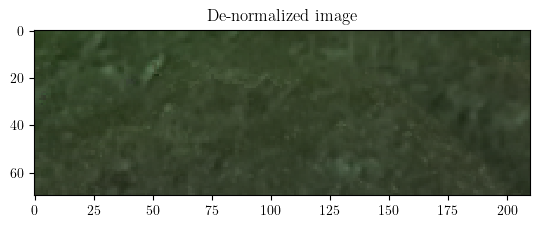

In [321]:
# Compute the test losses after successive removal of the samples with the highest loss and uncertainty
test_losses_loss, test_losses_uncertainty = uncertainty_relevance(model,
                                                                  device,
                                                                  criterion_classification,
                                                                  criterion_regression,
                                                                  bins_midpoints,
                                                                  uncertainty_function,
                                                                  test_set,
                                                                  test_regression_loss,
                                                                  test_regression_losses,
                                                                  uncertainties)

#### Plotting the results

Text(0, 0.5, 'Regression error (MSE)')

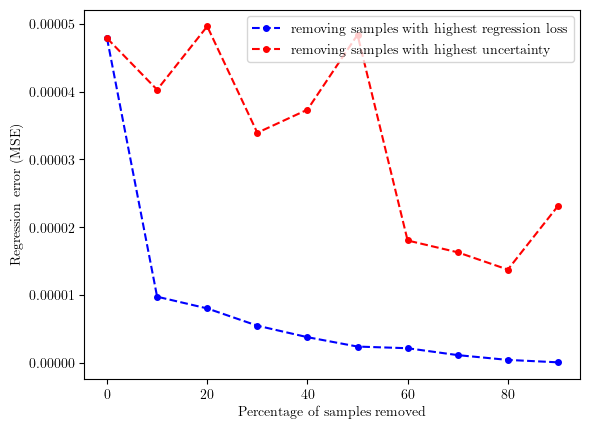

In [322]:
plt.plot(range(0, 100, 10), test_losses_loss, "bo--", label="removing samples with highest regression loss", markersize=4)
plt.plot(range(0, 100, 10), test_losses_uncertainty, "ro--", label="removing samples with highest uncertainty", markersize=4)

plt.legend(loc="upper right")
plt.xlabel("Percentage of samples removed")
plt.ylabel("Regression error (MSE)")

### Ensemble learning

#### Training the models

In [113]:
# Create a list of models
nb_models = 3
some_models = [ResNet18Velocity().to(device=device) for _ in range(nb_models)]

# Loop over the models
for i in range(nb_models):
    
    print(f"Training model {i+1}/{nb_models}")
    
    # Get all the parameters excepts the weights and bias of fc layer
    base_params = [param for name, param in some_models[i].named_parameters()
                   if name not in ["resnet18.fc.weight", "resnet18.fc.bias"]]

    # Define the optimizer, with a greater learning rate for the new fc layer
    optimizer = optim.SGD([
        {"params": base_params},
        {"params": some_models[i].resnet18.fc.parameters(), "lr": 1e-3},
    ],
        lr=1e-4, momentum=0.9, weight_decay=0.001)
    
    # Loop over the epochs
    for epoch in range(params.learning.NB_EPOCHS):

        # Train the model
        train_loss, train_accuracy, train_regression_loss = train(some_models[i],
                                                                  device,
                                                                  train_loader,
                                                                  optimizer,
                                                                  criterion_classification,
                                                                  criterion_regression,
                                                                  bins_midpoints,
                                                                  epoch)

Training model 1/3


Epoch 39 [train]: 100%|██████████| 22/22 [00:02<00:00, 10.65batch/s, batch_loss=1.3] 


Training model 2/3


Epoch 39 [train]: 100%|██████████| 22/22 [00:01<00:00, 11.42batch/s, batch_loss=1.35]


Training model 3/3


Epoch 39 [train]: 100%|██████████| 22/22 [00:02<00:00, 10.96batch/s, batch_loss=1.17]


In [114]:
def test_models(models, device, test_loader, criterion_classification, criterion_regression, bins_midpoints, uncertainty_function):
    """Test the models on the test set

    Args:
        models (list): List of models to test
        device (string): The device to use for the computations
        test_loader (Dataloader): The dataloader for the test set
        criterion_classification (Loss): The loss function for the classification task
        criterion_regression (Loss): The loss function for the regression task
        bins_midpoints (ndarray): The midpoints of the bins used for the discretization of the traversal cost
        uncertainty_function (function): The function to use to compute the uncertainty

    Returns:
        double, double, double, list, list: The average loss, the accuracy, the regression loss,
        the list of the uncertainties, the list of regression losses
    """
    # Testing
    test_regression_loss = 0.

    # Configure the models for testing
    for model in models:
        model.eval()

    test_regression_losses = []
    uncertainties = []

    with torch.no_grad():
        # Loop over the testing batches
        for images, traversal_costs, traversability_labels, linear_velocities in test_loader:

            images = images.to(device)
            traversal_costs = traversal_costs.to(device)
            linear_velocities = linear_velocities.type(torch.float32).to(device)
            
            # Add a dimension to the linear velocities tensor
            linear_velocities = linear_velocities.unsqueeze_(1)

            # expected_traversal_costs = torch.zeros(traversal_costs.shape[0], 1).to(device)
            
            # uncert = torch.zeros(traversal_costs.shape[0]).to(device)
            
            probabilities = torch.zeros(traversal_costs.shape[0], 10).to(device)
            
            exp_costs = torch.zeros(traversal_costs.shape[0], len(models)).to(device)
            
            # Perform forward pass
            for index, model in enumerate(models):
                
                predicted_traversability_labels = model(images, linear_velocities)

                # Apply the softmax function to the predicted traversability labels
                probabilities += nn.Softmax(dim=1)(predicted_traversability_labels)

                # Compute the expected traversal cost over the bins
                # expected_traversal_costs += torch.matmul(probabilities, bins_midpoints)
                
                # Compute the uncertainty
                # uncert += uncertainty_function(probabilities)
                
                exp_costs[:, index] = torch.matmul(nn.Softmax(dim=1)(predicted_traversability_labels), bins_midpoints)[:, 0]
            
            probabilities /= len(models)
            
            # Compute the expected traversal cost over the bins
            expected_traversal_costs = torch.matmul(probabilities, bins_midpoints)
            
            variance = torch.var(exp_costs, dim=1)
            uncertainties.append(variance.to("cpu"))
            
            # uncertainties.append(uncertainty_function(probabilities).to("cpu"))
                
            # Compute and accumulate the batch loss
            test_regression_loss += criterion_regression(expected_traversal_costs[:, 0], traversal_costs).item()

            # Compute the loss for each sample
            test_regression_losses.append(squared_error(expected_traversal_costs[:, 0], traversal_costs).to("cpu"))

    # Compute the regression loss
    test_regression_loss /= len(test_loader)
   
    return test_regression_loss, test_regression_losses, uncertainties

In [115]:
def uncertainty_relevance_models(models,
                          device,
                          criterion_classification,
                          criterion_regression,
                          bins_midpoints,
                          uncertainty_function,
                          test_set,
                          test_regression_loss,
                          test_regression_losses,
                          uncertainties,
                          nb_samples=len(test_set)):
    """Compute the regression losses after successive removal of the samples with the highest loss and uncertainty

    Args:
        model (Model): The model to test
        device (string): The device to use for the computations
        criterion_classification (Loss): The loss function for the classification task
        criterion_regression (Loss): The loss function for the regression task
        bins_midpoints (ndarray): The midpoints of the bins used for the discretization of the traversal cost
        uncertainty_function (function): The function to use to compute the uncertainty
        test_set (Dataset): The test set
        test_regression_loss (double): The regression loss on the test set
        test_regression_losses (list): The list of the regression losses for each sample
        uncertainties (list): The list of the uncertainties for each sample
        nb_samples (int, optional): The number of samples in the test set. Defaults to len(test_set).

    Returns:
        list, list: The list of the regression losses after successive removal of the samples with the highest loss,
        the list of the regression losses after successive removal of the samples with the highest uncertainty
    """
    # Create lists to store the test losses
    test_losses_loss = [test_regression_loss]
    test_losses_uncertainty = [test_regression_loss]
    
    # Concatenate the regression losses and convert to numpy array
    test_regression_losses = torch.cat(test_regression_losses, dim=0).numpy()

    # Concatenate the uncertainties and convert to numpy array
    uncertainties = torch.cat(uncertainties, dim=0).numpy()

    # Loop over the different percentages of samples to keep
    for i in range(1, 10):

        # Calculate the number of samples to keep
        nb_samples_to_keep = int((1 - i*0.1)*nb_samples)
        # Calculate the indices of the samples with the lowest losses
        indices_to_keep_loss = test_regression_losses.argsort()[:nb_samples_to_keep]
        # Calculate the indices of the samples with the lowest uncertainties
        indices_to_keep_uncertainty = uncertainties.argsort()[:nb_samples_to_keep]

        # Create a new test dataset without the samples with the largest losses
        test_set_loss = Subset(test_set, indices=indices_to_keep_loss)
        # Create a new test dataset without the samples with the largest uncertainties
        test_set_uncertainty = Subset(test_set, indices=indices_to_keep_uncertainty)

        # Create a new test dataloader without the samples with the largest losses
        test_loader_loss = DataLoader(test_set_loss,
                                      batch_size=BATCH_SIZE,
                                      shuffle=False,
                                      num_workers=12,
                                      pin_memory=True,
                                      )
        # Create a new test dataloader without the samples with the largest uncertainties
        test_loader_uncertainty = DataLoader(test_set_uncertainty,
                                             batch_size=BATCH_SIZE,
                                             shuffle=False,
                                             num_workers=12,
                                             pin_memory=True,
                                             )

        # Test the model on the new test dataset without the samples with the largest losses
        test_regression_loss_loss = test_models(models, 
                                         device,
                                         test_loader_loss,
                                         criterion_classification,
                                         criterion_regression,
                                         bins_midpoints,
                                         uncertainty_function)[0]
        # Test the model on the new test dataset without the samples with the largest uncertainties
        test_regression_loss_uncertainty = test_models(models,
                                                device,
                                                test_loader_uncertainty,
                                                criterion_classification,
                                                criterion_regression,
                                                bins_midpoints,
                                                uncertainty_function)[0]
        
        # Append the test loss to the list
        test_losses_loss.append(test_regression_loss_loss)
        test_losses_uncertainty.append(test_regression_loss_uncertainty)
        
    return test_losses_loss, test_losses_uncertainty

In [116]:
# Create arrays to store the test losses
# test_losses_loss = np.zeros((nb_models, 10))
# test_losses_uncertainty = np.zeros((nb_models, 10))

uncertainty_function = shannon_entropy

# Loop over the models
# for i in range(nb_models):
    
    
test_regression_loss, test_regression_losses, uncertainties = test_models(some_models,
                                                                          device,
                                                                          test_loader,
                                                                          criterion_classification,
                                                                          criterion_regression,
                                                                          bins_midpoints,
                                                                          uncertainty_function)
print("Test regression loss: ", test_regression_loss)

# Compute the test losses after successive removal of the samples with the highest loss and uncertainty
test_losses_loss, test_losses_uncertainty = uncertainty_relevance_models(some_models,
                                                                  device,
                                                                  criterion_classification,
                                                                  criterion_regression,
                                                                  bins_midpoints,
                                                                  uncertainty_function,
                                                                  test_set,
                                                                  test_regression_loss,
                                                                  test_regression_losses,
                                                                  uncertainties)

Test regression loss:  0.00031919827654147063


#### Plotting the results

Text(0, 0.5, 'Regression error (MSE)')

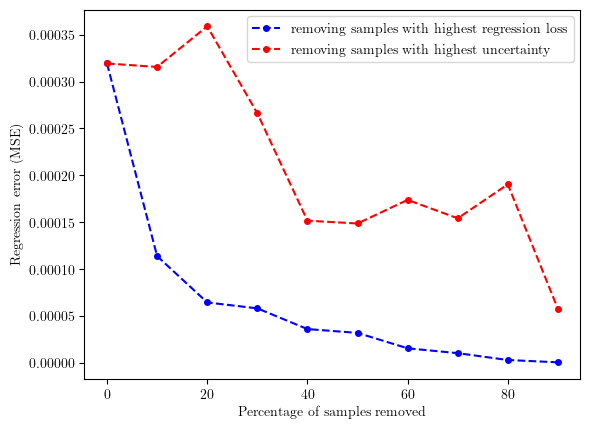

In [117]:
plt.plot(range(0, 100, 10), test_losses_loss, "bo--", label="removing samples with highest regression loss", markersize=4)
plt.plot(range(0, 100, 10), test_losses_uncertainty, "ro--", label="removing samples with highest uncertainty", markersize=4)

plt.legend(loc="upper right")
plt.xlabel("Percentage of samples removed")
plt.ylabel("Regression error (MSE)")